## Gaussian decomposable graphical model

Fitting multiple Gaussian decomposable graphical model to simulated G from auto-regressive process

In [5]:
SAVE_PLOTS = True
SAVE_IMG_LOC =  '/home/mo/src/decomposable_paper/img/'
SAVE_LOC = '/home/mo/src/decomposable_paper/img/'

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import time
from parallelDG.graph import trajectory
import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.distributions.g_intra_class as gic
import parallelDG.auxiliary_functions as aux
from parallelDG.distributions import discrete_dec_log_linear as loglin
import parallelDG.mh_parallel as pdg
from networkx.drawing.nx_pydot import graphviz_layout
sns.set_style("whitegrid")
options = {
    "font_size": 8,
    "node_size": 100,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
def save_location(filename, loc = SAVE_IMG_LOC):
    if SAVE_PLOTS:
        plt.savefig(loc + filename + '.png', dpi = 600, bbox_inches='tight')
    else: 
        plt.show()

### Simulating AR(1-5) Gaussian graphical model

In [3]:
p = 50
sigma2 = 1.0
rho = 0.9
n = 100
delta = 5

Number of edges 85, number of nodes 50
loglikelihood 1592.785678


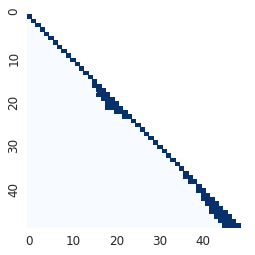

In [9]:
np.random.seed(2) # generates same data as in the paper
ar_graph = dlib.sample_random_AR_graph(n_dim=p, max_bandwidth=delta)
aux.plot_heatmap(nx.to_numpy_array(ar_graph), xticklabels=10, yticklabels=10)
ar_cov_mat = gic.cov_matrix(ar_graph, rho, sigma2)
ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(p), ar_cov_mat, n))
print('Number of edges {}, number of nodes {}'.format(ar_graph.size(), ar_graph.order()))
print('loglikelihood {:2f}'.format(pdg.ggm_loglikelihood(dataframe=ar_df,
                                                         graph=ar_graph,
                                                         graph_prior=['uniform'], 
                                                         delta=delta)))
#save_location('ggm_true_graph_adj')

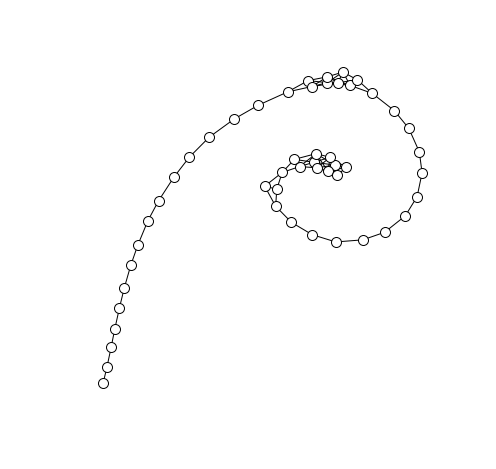

In [10]:
# Graph
plt.figure(figsize=(8,8))
pos = graphviz_layout(ar_graph, prog="fdp",)
nx.draw_networkx(ar_graph,pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
save_location('ggm_true_graph')

In [11]:
n_samples = 500000
randomize  = 100
graph_prior = ['uniform']
delta = 5.0
burnin = 200000
seed = 0# 12345

##  Multiple runs

In [12]:
randomize  = 100
graph_prior = ['uniform', 2.0, 4.0]
delta = 5.0
burnin = 200000
def multiple_runs(seed, parallel = False):
    import json
    if not parallel:
        n_samples = 1000000
        traj = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed,
                                 parallel = parallel)
        
    else:
        n_samples = 500000
        traj = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                     n_samples=n_samples,
                                     randomize=randomize, 
                                     graph_prior = graph_prior,
                                     delta = delta, 
                                     seed = seed,
                                     parallel=parallel)
    traj.graph_updates = None
    traj.set_graph_trajectories(index_type = 'mcmc_index')
    acc_mcmc_index = aux.acceptance_ratio(traj.trajectory)
    traj.graph_updates = None
    traj.set_graph_trajectories(index_type = 'mcmc_subindex')
    acc_mcmc_subindex = aux.acceptance_ratio(traj.trajectory)
        ## of the juncion tree
    up = [0] * traj.n_updates
    for x in traj.jt_updates: 
        up[x[1]-1] = 1
        
    traj._size=None
    traj.graph_updates = None
    traj.set_graph_trajectories(index_type = 'mcmc_index')
    traj.size().plot(color = 'black')
    size_mcmc_index = list(traj._size)
    
    traj._size=None
    traj.graph_updates = None
    traj.set_graph_trajectories(index_type = 'mcmc_subindex')
    traj.size().plot(color = 'black')
    size_mcmc_subindex = list(traj._size)

    burnin = 50000
    lag=20000
    df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:],
                   'mcmc_subindex': size_mcmc_subindex[-burnin:]})
    y_index = aux.autocorrelation_plot(df['mcmc_index'], label = 'MCMC index', 
                                 color = 'black', 
                                 lag =lag, 
                                 return_series=True)
    y_subindex = aux.autocorrelation_plot(df['mcmc_subindex'], 
                                              label = ' MCMC subindex',
                                              color = 'black',
                                              ls = ':', lag = lag,
                                              return_series=True)
        ## SAVE JSON
    data = {
            "autocorr_index" : y_index, 
            "autocorr_subindex": y_subindex, 
            "lag" : lag, 
            "burnin_last": burnin, 
            "size_mcmc_index" : size_mcmc_index, 
            "size_mcmc_subindex" :size_mcmc_subindex, 
            "acc_mcmc_index" : list(acc_mcmc_index[1]), 
            "acc_avg_index" : acc_mcmc_index[0],
            "acc_mcmc_subindex": list(acc_mcmc_subindex[1]), 
            "acc_avg_subindex" : acc_mcmc_subindex[0],
            "acc_mcmc_junction" : up, 
            "logl" : traj.logl,
        }
    if not parallel: 
        filename = SAVE_LOC + str(seed) + 'single_move.json'
    else:
        filename = SAVE_LOC + str(seed) + '.json'
    with open(filename, 'w') as outfile:
        json.dump(data, outfile)
    print('saved file:' + SAVE_LOC)

In [13]:
### Plotting multple autocorrelation plots
import json
def read_file(filename):
    """ Reads a trajectory from json-file.
    """
    with open(filename) as mcmc_file:
        mcmc_json = json.load(mcmc_file)
    return mcmc_json
    
def get_variable(variable, extra_name = ''):
    seeds = list(range(10))
    data = dict()
    for s in seeds: 
        filename = SAVE_LOC + str(s) + extra_name + '.json'
        d = read_file(filename)
        data[s] = d[variable]
    return data

# Start of run

Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:28<00:00, 11295.54it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11291.77updates/sec
Acceptance rate 0.1612
mcmc_index
Acceptance ratio 0.019990
mcmc_subindex
Acceptance ratio 0.019967
mcmc_index
mcmc_subindex


Metropolis-Hastings - single-move:   0%|          | 456/999999 [00:00<03:39, 4555.54it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:59<00:00, 8391.49it/s] 


Total of 1000000 updates, for an average of 1.00 per iteration or 8389.79updates/sec
Acceptance rate 0.1509
mcmc_index
Acceptance ratio 0.016954
mcmc_subindex
Acceptance ratio 0.016921
mcmc_index
mcmc_subindex


Metropolis-Hastings - single-move:   0%|          | 500/999999 [00:00<03:20, 4983.86it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:25<00:00, 11675.91it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11671.32updates/sec
Acceptance rate 0.1499
mcmc_index
Acceptance ratio 0.014580
mcmc_subindex
Acceptance ratio 0.014559
mcmc_index
mcmc_subindex
saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:28<00:00, 11358.73it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11354.68updates/sec
Acceptance rate 0.1511
mcmc_index
Acceptance ratio 0.014004
mcmc_subindex
Acceptance ratio 0.013977
mcmc_index
mcmc_subindex


Metropolis-Hastings - single-move:   0%|          | 587/999999 [00:00<02:50, 5867.54it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:30<00:00, 11003.40it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 10999.52updates/sec
Acceptance rate 0.1518
mcmc_index
Acceptance ratio 0.017669
mcmc_subindex
Acceptance ratio 0.017639
mcmc_index
mcmc_subindex


Metropolis-Hastings - single-move:   0%|          | 500/999999 [00:00<03:21, 4958.25it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:28<00:00, 11270.26it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11266.06updates/sec
Acceptance rate 0.1504
mcmc_index
Acceptance ratio 0.016165
mcmc_subindex
Acceptance ratio 0.016147
mcmc_index
mcmc_subindex


Metropolis-Hastings - single-move:   0%|          | 594/999999 [00:00<02:48, 5931.87it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:29<00:00, 11133.84it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11130.31updates/sec
Acceptance rate 0.1526
mcmc_index
Acceptance ratio 0.017873
mcmc_subindex
Acceptance ratio 0.017839
mcmc_index
mcmc_subindex
saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:28<00:00, 11293.56it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11289.82updates/sec
Acceptance rate 0.1520
mcmc_index
Acceptance ratio 0.017035
mcmc_subindex
Acceptance ratio 0.017009
mcmc_index
mcmc_subindex


Metropolis-Hastings - single-move:   0%|          | 557/999999 [00:00<02:59, 5564.82it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:30<00:00, 11102.23it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11098.19updates/sec
Acceptance rate 0.1530
mcmc_index
Acceptance ratio 0.017599
mcmc_subindex
Acceptance ratio 0.017569
mcmc_index
mcmc_subindex


Metropolis-Hastings - single-move:   0%|          | 500/999999 [00:00<03:33, 4692.37it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:29<00:00, 11226.87it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11222.62updates/sec
Acceptance rate 0.1527
mcmc_index
Acceptance ratio 0.016558
mcmc_subindex
Acceptance ratio 0.016534
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 370/499999 [00:00<02:15, 3687.39it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [01:02<00:00, 7946.80it/s]


Total of 1241407 updates, for an average of 2.48 per iteration or 19723.25updates/sec
Acceptance rate 0.4895
mcmc_index
Acceptance ratio 0.077194
mcmc_subindex
Acceptance ratio 0.032415
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 405/499999 [00:00<02:03, 4036.40it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [00:59<00:00, 8466.92it/s]


Total of 1233925 updates, for an average of 2.47 per iteration or 20886.83updates/sec
Acceptance rate 0.4880
mcmc_index
Acceptance ratio 0.074618
mcmc_subindex
Acceptance ratio 0.031482
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 358/499999 [00:00<02:19, 3578.57it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [01:01<00:00, 8150.42it/s] 


Total of 1230414 updates, for an average of 2.46 per iteration or 20049.14updates/sec
Acceptance rate 0.4863
mcmc_index
Acceptance ratio 0.074358
mcmc_subindex
Acceptance ratio 0.031457
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 382/499999 [00:00<02:10, 3818.82it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [00:55<00:00, 9047.98it/s] 


Total of 1232430 updates, for an average of 2.46 per iteration or 22292.33updates/sec
Acceptance rate 0.4868
mcmc_index
Acceptance ratio 0.075700
mcmc_subindex
Acceptance ratio 0.031965
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 376/499999 [00:00<02:12, 3756.73it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [01:04<00:00, 7728.69it/s] 


Total of 1231256 updates, for an average of 2.46 per iteration or 19024.58updates/sec
Acceptance rate 0.4862
mcmc_index
Acceptance ratio 0.079332
mcmc_subindex
Acceptance ratio 0.033672
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 335/499999 [00:00<02:29, 3349.87it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [01:00<00:00, 8332.96it/s]


Total of 1231985 updates, for an average of 2.46 per iteration or 20522.35updates/sec
Acceptance rate 0.4861
mcmc_index
Acceptance ratio 0.077434
mcmc_subindex
Acceptance ratio 0.032789
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 366/499999 [00:00<02:16, 3657.11it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [00:59<00:00, 8418.77it/s]


Total of 1238241 updates, for an average of 2.48 per iteration or 20839.67updates/sec
Acceptance rate 0.4887
mcmc_index
Acceptance ratio 0.075974
mcmc_subindex
Acceptance ratio 0.032039
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 358/499999 [00:00<02:19, 3576.18it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [01:02<00:00, 7969.08it/s]


Total of 1234380 updates, for an average of 2.47 per iteration or 19664.96updates/sec
Acceptance rate 0.4866
mcmc_index
Acceptance ratio 0.076536
mcmc_subindex
Acceptance ratio 0.032434
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 292/499999 [00:00<02:53, 2873.67it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [01:38<00:00, 5061.97it/s]


Total of 1230156 updates, for an average of 2.46 per iteration or 12449.14updates/sec
Acceptance rate 0.4858
mcmc_index
Acceptance ratio 0.076518
mcmc_subindex
Acceptance ratio 0.032400
mcmc_index
mcmc_subindex


Metropolis-Hastings - parallel moves:   0%|          | 465/499999 [00:00<01:47, 4643.68it/s]

saved file:/home/mo/src/decomposable_paper/img/


Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [00:59<00:00, 8459.68it/s] 


Total of 1231686 updates, for an average of 2.46 per iteration or 20826.02updates/sec
Acceptance rate 0.4865
mcmc_index
Acceptance ratio 0.076250
mcmc_subindex
Acceptance ratio 0.032222
mcmc_index
mcmc_subindex
saved file:/home/mo/src/decomposable_paper/img/
CPU times: user 3h 4min 48s, sys: 2min 21s, total: 3h 7min 9s
Wall time: 3h 6min 10s


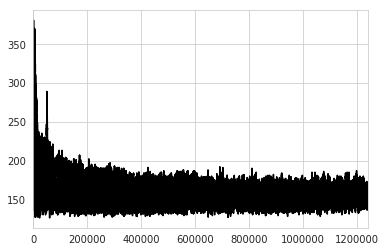

In [14]:
%%time
seeds = [0,1,2,3,4,5,6,7,8,9]
# multi-move
for s in seeds: 
    multiple_runs(s)
# single-move
for s in seeds: 
    multiple_runs(s, True)
#multiple_runs(seeds)

In [15]:
data = get_variable('autocorr_index')
x = np.arange(len(data[0])) + 1
datasub = get_variable('autocorr_subindex')

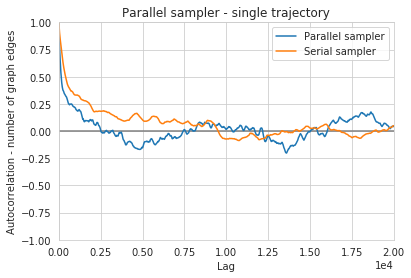

In [17]:
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
i = 1
ax.plot(x, data[i], label = 'Parallel sampler')
ax.plot(x, datasub[i], label = 'Serial sampler')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - single trajectory')
plt.legend()
save_location('ggm_traj_autocorrelation_index_sub')

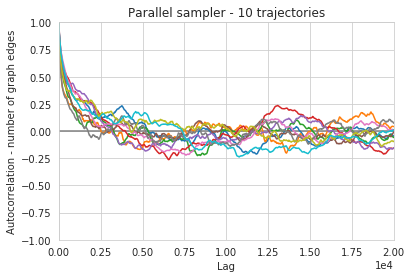

In [18]:
data = get_variable('autocorr_index')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for key, y in data.items(): 
    ax.plot(x, y)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_autocorrelation')

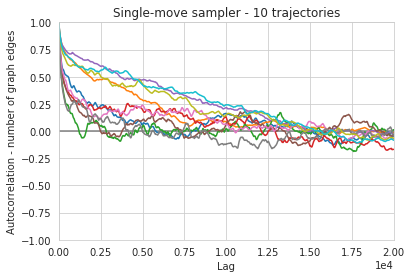

In [19]:
data = get_variable('autocorr_index', 'single_move')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
#ax.set_ylabel("Autocorrelation")
for key, y in data.items(): 
    ax.plot(x, y)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_autocorrelation_single_move')    

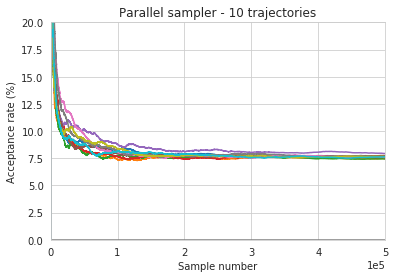

In [20]:
data = get_variable('acc_mcmc_index')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(0, 20))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
for key, y in data.items(): 
    ax.plot(x, np.array(y) * 100.0)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_acceptance_ratio')

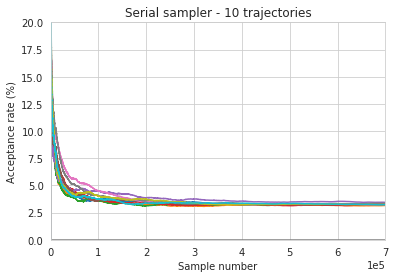

In [21]:
data = get_variable('acc_mcmc_subindex')
max_x = 700000
x = np.arange(max_x) + 1
ax = plt.gca(xlim=(1, max_x), ylim=(0, 20))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
for key, y in data.items(): 
    ax.plot(x, np.array(y[:max_x])* 100.0)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Serial sampler - 10 trajectories')
save_location('ggm_10_traj_acceptance_ratio_subindex')

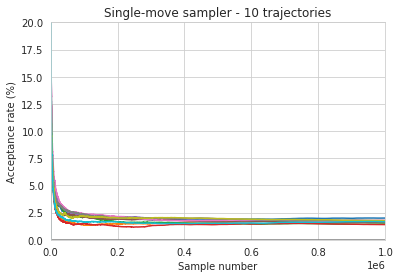

In [22]:
data = get_variable('acc_mcmc_index', 'single_move')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(0, 20))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
for key, y in data.items(): 
    ax.plot(x, np.array(y) * 100.0)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_acceptance_ratio_single_move')

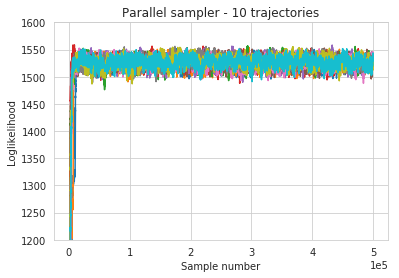

In [23]:
data = get_variable('logl')
burnin = 0
for key, y in data.items():
    yy = y[-burnin:]
    x = list(range(len(yy)))
    plt.plot(x, yy)

plt.xlabel('Sample number')
plt.ylabel('Loglikelihood')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylim((1200,1600))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_loglikelihood_traceplot')

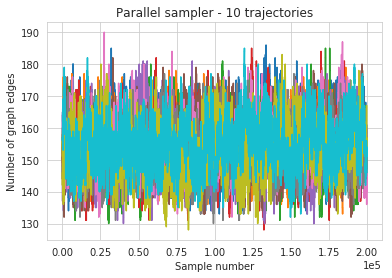

In [24]:
data = get_variable('size_mcmc_index')
burnin = 200000
x = list(range(burnin))
for key, y in data.items():
    plt.plot(x, y[-burnin:])

plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_size_traceplot')

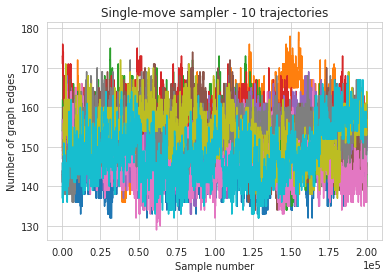

In [25]:
data = get_variable('size_mcmc_index', 'single_move')
burnin = 200000
x = list(range(burnin))
for key, y in data.items():
    plt.plot(x, y[-burnin:])

plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_size_traceplot_single_move')

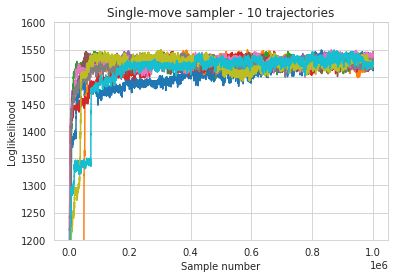

In [26]:
data = get_variable('logl', 'single_move')
burnin = 0
for key, y in data.items():
    yy = y[-burnin:]
    x = list(range(len(yy)))
    plt.plot(x, yy)

plt.xlabel('Sample number')
plt.ylabel('Loglikelihood')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylim((1200,1600))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_loglikelihood_traceplot_single_move')

In [27]:
data = get_variable('acc_mcmc_index')
datasub = get_variable('acc_mcmc_subindex')
x = np.arange(len(datasub[0])) + 1
datasingle = get_variable('acc_mcmc_index', 'single_move')

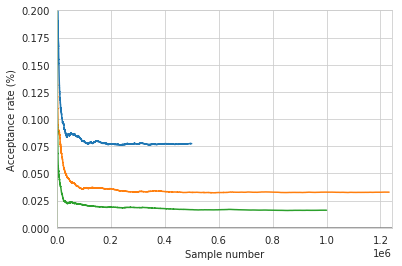

In [28]:
i = 5#1,8,5
max_x = np.max(x)
ax = plt.gca(xlim=(1, max_x), ylim=(0, 0.2))
y = data[i]
z = datasub[i]
f = datasingle[i]
ax.plot(list(range(len(y))), y, label = 'MCMC index')
ax.plot(list(range(len(z))), z, label = 'MCMC subindex')
ax.plot(list(range(len(f))), f, label = 'single-move')
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#plt.title('Parallel sampler - MCMC subindex - 10 trajectories')
#save_location('ggm_10_traj_acceptance_ratio_subindex')